In [1]:
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))


columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]
df = (pl.read_parquet('/kaggle/input/gameplay-predict/train.parquet')

      .with_columns(columns))

df1 = df.filter(pl.col("level_group") == '0-4')
df2 = df.filter(pl.col("level_group") == '5-12')
df3 = df.filter(pl.col("level_group") == '13-22')

CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you', 'flag', 'can','and','is','the','to']
name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']


LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter(pl.col('text').str.contains(c)).max().alias(f'word_max_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter(pl.col('text').str.contains(c)).sum().alias(f'word_sum_{c}') for c in DIALOGS],

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).quantile(0.1, "nearest").alias(f"{c}_quantile1_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.2, "nearest").alias(f"{c}_quantile2_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.4, "nearest").alias(f"{c}_quantile4_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.6, "nearest").alias(f"{c}_quantile6_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.8, "nearest").alias(f"{c}_quantile8_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.9, "nearest").alias(f"{c}_quantile9_{feature_suffix}") for c in NUMS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],

        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}")
          for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.1, "nearest").alias(
            f"{c}_ET_quantile1_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.2, "nearest").alias(
            f"{c}_ET_quantile2_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.4, "nearest").alias(
            f"{c}_ET_quantile4_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.6, "nearest").alias(
            f"{c}_ET_quantile6_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.8, "nearest").alias(
            f"{c}_ET_quantile8_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.9, "nearest").alias(
            f"{c}_ET_quantile9_{feature_suffix}") for c in event_name_feature],
        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c
          in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(
            f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(
            f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],

    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text") == "Here's the log book.")
                                              | (pl.col("fqid") == 'logbook.page.bingo'))
                    .apply(lambda s: s.max() - s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                        pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                        pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)


    return train

df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.9].index)
drop2 = list(null2[null2 > 0.9].index)
drop3 = list(null3[null3 > 0.9].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        print(col)
        drop1.append(col)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        print(col)
        drop2.append(col)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        print(col)
        drop3.append(col)

df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')


FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

712 544 474


 23%|██▎       | 440/1873 [00:00<00:00, 4386.25it/s]

word_flag
elapsed_time_diff_min_
worker_fqid_counts
archivist_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
flag_girl_fqid_counts
archivist_glasses_fqid_counts
journals_fqid_counts
seescratches_fqid_counts
groupconvo_flag_fqid_counts
expert_fqid_counts
businesscards_fqid_counts
ch3start_fqid_counts
tofrontdesk_fqid_counts
savedteddy_fqid_counts
glasses_fqid_counts
tunic.drycleaner_fqid_counts
reader_flag_fqid_counts
tunic.library_fqid_counts
tracks_fqid_counts
tunic.capitol_2_fqid_counts
trigger_scarf_fqid_counts
reader_fqid_counts
tunic.capitol_1_fqid_counts
journals.pic_0.next_fqid_counts
unlockdoor_fqid_counts
what_happened_fqid_counts
tunic.humanecology_fqid_counts
colorbook_fqid_counts
logbook_fqid_counts
businesscards.card_0.next_fqid_counts
journals.hub.topics_fqid_counts
logbook.page.bingo_fqid_counts
journals.pic_1.next_fqid_counts
journals_flag_fqid_counts
reader.paper0.next_fqid_counts
tracks.hub.deer_fqid_counts
reader_flag.paper0.next_fqid_counts
trigger_c

100%|██████████| 1873/1873 [00:00<00:00, 5074.52it/s]


tunic.wildlife.center_room_fqid_counts
tunic.historicalsociety.cage_room_fqid_counts
tunic.library.frontdesk_room_fqid_counts
tunic.historicalsociety.frontdesk_room_fqid_counts
tunic.historicalsociety.closet_dirty_room_fqid_counts
tunic.humanecology.frontdesk_room_fqid_counts
tunic.library.microfiche_room_fqid_counts
tunic.drycleaner.frontdesk_room_fqid_counts
tunic.flaghouse.entry_room_fqid_counts
tunic.historicalsociety.collection_flag_room_fqid_counts
tunic.capitol_1.hall_room_fqid_counts
tunic.capitol_2.hall_room_fqid_counts
checkpoint_ET_std_
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
5-12_LEVEL_group_count
13-22_LEVEL_group_count
1tunic.wildlife.center_level_room_count
1tunic.historicalsociety.cage_level_room_count
1tunic.library.frontdesk_level_room_count
1tuni

  0%|          | 0/1879 [00:00<?, ?it/s]

word_flag
elapsed_time_diff_min_
wells_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
groupconvo_fqid_counts


 45%|████▍     | 838/1879 [00:00<00:00, 4267.88it/s]

flag_girl_fqid_counts
archivist_glasses_fqid_counts
seescratches_fqid_counts
groupconvo_flag_fqid_counts
cs_fqid_counts
teddy_fqid_counts
expert_fqid_counts
ch3start_fqid_counts
savedteddy_fqid_counts
glasses_fqid_counts
reader_flag_fqid_counts
tracks_fqid_counts
tunic.capitol_2_fqid_counts
unlockdoor_fqid_counts
colorbook_fqid_counts
journals_flag_fqid_counts
tracks.hub.deer_fqid_counts
reader_flag.paper0.next_fqid_counts
journals_flag.pic_0.bingo_fqid_counts
plaque.face.date_fqid_counts
notebook_fqid_counts
tunic.wildlife_fqid_counts
tocage_fqid_counts
tocollectionflag_fqid_counts
chap4_finale_c_fqid_counts
lockeddoor_fqid_counts
journals_flag.hub.topics_fqid_counts
reader_flag.paper2.bingo_fqid_counts
tunic.flaghouse_fqid_counts
directory.closeup.archivist_fqid_counts
intro_fqid_counts
retirement_letter_fqid_counts
remove_cup_fqid_counts
journals_flag.pic_0.next_fqid_counts
coffee_fqid_counts
key_fqid_counts
togrampa_fqid_counts
reader_flag.paper1.next_fqid_counts
chap1_finale_fqid_

 95%|█████████▍| 1778/1879 [00:00<00:00, 4576.80it/s]

tunic.wildlife.center_room_fqid_counts
tunic.historicalsociety.cage_room_fqid_counts
tunic.historicalsociety.closet_room_fqid_counts
tunic.flaghouse.entry_room_fqid_counts
tunic.historicalsociety.collection_flag_room_fqid_counts
tunic.capitol_2.hall_room_fqid_counts
checkpoint_event_name_counts
checkpoint_ET_std_
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
0-4_LEVEL_group_count
13-22_LEVEL_group_count
1tunic.historicalsociety.entry_level_room_count
1tunic.wildlife.center_level_room_count
1tunic.historicalsociety.cage_level_room_count
1tunic.library.frontdesk_level_room_count
1tunic.historicalsociety.frontdesk_level_room_count
1tunic.historicalsociety.stacks_level_room_count
1tunic.historicalsociety.closet_dirty_level_room_count
1tunic.humanecology.frontdesk_level_room_count
1tunic.historicalsociety.basement_level_room_count
1t

100%|██████████| 1879/1879 [00:00<00:00, 4485.06it/s]


22tunic.capitol_1.hall_level_room_count
22tunic.capitol_0.hall_level_room_count
22tunic.capitol_2.hall_level_room_count


  0%|          | 0/1877 [00:00<?, ?it/s]

elapsed_time_diff_min_

 20%|██        | 384/1877 [00:00<00:00, 3820.73it/s]


archivist_fqid_counts
groupconvo_fqid_counts
cs_fqid_counts
trigger_scarf_fqid_counts
what_happened_fqid_counts
logbook.page.bingo_fqid_counts
trigger_coffee_fqid_counts
wellsbadge_fqid_counts
plaque.face.date_fqid_counts
notebook_fqid_counts
businesscards.card_bingo.bingo_fqid_counts
chap2_finale_c_fqid_counts
tunic.capitol_0_fqid_counts
intro_fqid_counts
reader.paper2.bingo_fqid_counts
retirement_letter_fqid_counts
magnify_fqid_counts
togrampa_fqid_counts
janitor_fqid_counts
chap1_finale_fqid_counts
report_fqid_counts
chap1_finale_c_fqid_counts
door_block_talk_fqid_counts
block_magnify_fqid_counts
block_fqid_counts
block_0_fqid_counts
door_block_clean_fqid_counts
doorblock_fqid_counts
tocloset_fqid_counts
block_tomap2_fqid_counts
block_tocollection_fqid_counts
block_tomap1_fqid_counts
block_badge_fqid_counts
block_badge_2_fqid_counts
block_1_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tu

100%|██████████| 1877/1877 [00:00<00:00, 3219.42it/s]

tunic.historicalsociety.closet_room_fqid_counts
tunic.capitol_0.hall_room_fqid_counts
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
0-4_LEVEL_group_count
5-12_LEVEL_group_count
1tunic.historicalsociety.entry_level_room_count
1tunic.wildlife.center_level_room_count
1tunic.historicalsociety.cage_level_room_count
1tunic.library.frontdesk_level_room_count
1tunic.historicalsociety.frontdesk_level_room_count
1tunic.historicalsociety.stacks_level_room_count
1tunic.historicalsociety.closet_dirty_level_room_count
1tunic.humanecology.frontdesk_level_room_count
1tunic.historicalsociety.basement_level_room_count
1tunic.kohlcenter.halloffame_level_room_count
1tunic.library.microfiche_level_room_count
1tunic.drycleaner.frontdesk_level_room_count
1tunic.historicalsociety.collection_level_room_count
1tunic.historicalsociety.closet_level_room_count
1tunic.flaghouse.entry_level_ro

We will train with 531 821 1001 features
We will train with 11779 users info


  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with531features
#########################


,mean
feature,
tunic.capitol_0.hall_ET_sum_,2.121286
checkpoint_ET_mean_,1.852476
plaque_fqid_counts,1.839435
chap1_finale_c_ET_sum_,1.787653
checkpoint_ET_quantile4_,1.724189
checkpoint_ET_quantile9_,1.717474
3tunic.historicalsociety.collection_level_room_count,1.688413
checkpoint_ET_sum_,1.579987
cutscene_click_ET_quantile4_,1.542416


  6%|▌         | 1/18 [03:35<1:01:08, 215.81s/it]

#########################
question2, with531features
#########################


,mean
feature,
basic_name_counts,2.101746
object_click_event_name_counts,2.101572
4_ET_sum_,1.875873
tunic.capitol_0.hall_ET_sum_,1.697605
retirement_letter_ET_std_,1.475243
cutscene_click_ET_quantile2_,1.419121
checkpoint_ET_quantile1_,1.355819
checkpoint_ET_quantile9_,1.328274
chap1_finale_c_ET_sum_,1.287312


 11%|█         | 2/18 [06:25<50:14, 188.43s/it]  

#########################
question3, with531features
#########################


,mean
feature,
basic_name_counts,3.066588
object_click_event_name_counts,2.021262
checkpoint_ET_quantile2_,1.937095
checkpoint_ET_quantile1_,1.917970
4_ET_sum_,1.845050
checkpoint_ET_quantile6_,1.803705
checkpoint_ET_quantile8_,1.757861
checkpoint_ET_mean_,1.626132
checkpoint_ET_quantile9_,1.551058


 17%|█▋        | 3/18 [09:11<44:36, 178.42s/it]

#########################
question4, with821features
#########################


,mean
feature,
person_click_ET_quantile2_,3.238937
person_click_ET_quantile1_,3.219759
person_click_ET_quantile4_,3.119921
tunic.library.frontdesk.worker.wells_ET_sum_,1.971966
tunic.library.frontdesk.worker.wells_ET_mean_,1.938626
5-12_LEVEL_group_count,1.567392
basic_name_counts,1.487930
logbook.page.bingo_ET_mean_,1.482872
session_number_,1.403887


 22%|██▏       | 4/18 [12:52<45:31, 195.08s/it]

#########################
question5, with821features
#########################


,mean
feature,
session_number_,1.892675
person_click_ET_quantile2_,1.541000
basic_name_counts,1.511961
5-12_LEVEL_group_count,1.486891
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.364940
person_click_ET_quantile1_,1.355345
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.074390
tunic.historicalsociety.frontdesk.archivist.have_glass_ET_std_,1.049794
notebook_click_ET_quantile9_,0.944431


 28%|██▊       | 5/18 [17:31<48:48, 225.30s/it]

#########################
question6, with821features
#########################


,mean
feature,
person_click_ET_quantile1_,1.536778
11_LEVEL_count,1.328078
basic_name_counts,1.093168
session_number_,1.058347
trigger_scarf_ET_std_,1.034953
hover_duration_quantile8_,0.978228
businesscards_ET_std_,0.911321
5-12_LEVEL_group_count,0.842695
logbook.page.bingo_ET_std_,0.814018


 33%|███▎      | 6/18 [23:04<52:25, 262.09s/it]

#########################
question7, with821features
#########################


,mean
feature,
person_click_ET_quantile1_,1.790002
hover_duration_mean_,1.216836
5-12_LEVEL_group_count,1.190009
reader.paper1.next_ET_mean_,1.150773
hover_duration_quantile8_,0.952876
10_ET_std_,0.920939
tunic.historicalsociety.frontdesk_room_fqid_counts,0.906333
session_number_,0.882448
word_std_you,0.872828


 39%|███▉      | 7/18 [27:50<49:28, 269.84s/it]

#########################
question8, with821features
#########################


,mean
feature,
person_click_ET_quantile2_,1.779943
person_click_ET_quantile4_,1.475119
session_number_,1.453651
basic_name_counts,1.164195
5-12_LEVEL_group_count,1.119490
person_click_ET_quantile1_,1.040615
word_std_this,1.015445
11_LEVEL_count,0.966520
reader_bingo_duration,0.959693


 44%|████▍     | 8/18 [30:19<38:33, 231.30s/it]

#########################
question9, with821features
#########################


,mean
feature,
11_LEVEL_count,2.470136
basic_name_counts,1.444304
5-12_LEVEL_group_count,1.417475
person_click_ET_quantile1_,1.154728
notebook_click_ET_quantile9_,1.115441
businesscards.card_0.next_ET_mean_,1.101492
session_number_,1.071801
logbook.page.bingo_ET_sum_,0.996839
hover_duration_quantile8_,0.891833


 50%|█████     | 9/18 [34:27<35:29, 236.64s/it]

#########################
question10, with821features
#########################


,mean
feature,
11_LEVEL_count,2.447020
basic_name_counts,2.057868
person_click_ET_quantile1_,1.689027
journals_ET_sum_,1.466618
tunic.historicalsociety.stacks_ET_sum_,1.280674
person_click_ET_quantile2_,1.245060
session_number_,1.142475
object_click_event_name_counts,1.105400
5-12_LEVEL_group_count,1.081875


 56%|█████▌    | 10/18 [38:28<31:43, 237.90s/it]

#########################
question11, with821features
#########################


,mean
feature,
session_number_,1.321405
tostacks_ET_sum_,1.239902
5-12_LEVEL_group_count,1.107621
basic_name_counts,0.949909
undefined_name_counts,0.880992
object_click_event_name_counts,0.879110
11_LEVEL_count,0.853576
reader_fqid_counts,0.690345
tunic.historicalsociety.frontdesk_room_fqid_counts,0.666210


 61%|██████    | 11/18 [42:41<28:17, 242.52s/it]

#########################
question12, with821features
#########################


,mean
feature,
logbook.page.bingo_ET_sum_,1.486291
hover_duration_quantile8_,1.336627
12_ET_sum_,1.203233
businesscards_ET_mean_,1.061217
person_click_ET_quantile1_,1.057139
5-12_LEVEL_group_count,1.043812
logbook.page.bingo_ET_mean_,0.954664
6tunic.historicalsociety.entry_level_room_count,0.903774
reader_fqid_counts,0.801587


 67%|██████▋   | 12/18 [46:15<23:23, 233.94s/it]

#########################
question13, with821features
#########################


,mean
feature,
object_click_event_name_counts,3.426185
journals_bingo_duration,1.657737
reader_bingo_duration,1.112537
object_click_ET_sum_,0.941884
logbook_bingo_duration,0.909510
11_LEVEL_count,0.884549
11tunic.historicalsociety.stacks_level_room_count,0.851068
businesscards_fqid_counts,0.831555
room_coor_x_quantile1_,0.783384


 72%|███████▏  | 13/18 [51:01<20:49, 249.84s/it]

#########################
question14, with1001features
#########################


,mean
feature,
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,1.439031
20_LEVEL_count,1.417530
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,1.230376
13-22_LEVEL_group_count,1.121609
person_click_ET_quantile1_,1.005928
session_number_,0.981644
journals_flag.pic_1.next_ET_sum_,0.913725
word_to,0.870688
word_the,0.794713


 78%|███████▊  | 14/18 [55:35<17:08, 257.08s/it]

#########################
question15, with1001features
#########################


,mean
feature,
tunic.historicalsociety.entry.boss.flag_ET_mean_,1.390316
tunic.flaghouse.entry.colorbook_ET_sum_,1.317220
tunic.flaghouse.entry.colorbook_ET_mean_,1.257384
word_to,1.143103
tracks_ET_sum_,1.061423
word_std_this,1.051436
map_click_event_name_counts,0.946606
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.869459
13-22_LEVEL_group_count,0.840211


 83%|████████▎ | 15/18 [1:00:54<13:46, 275.58s/it]

#########################
question16, with1001features
#########################


,mean
feature,
19_ET_std_,1.232833
journals_flag.pic_2.next_ET_mean_,0.983066
teddy_ET_std_,0.974242
tunic.flaghouse.entry_ET_std_,0.940513
colorbook_ET_std_,0.830874
hover_duration_quantile6_,0.675879
directory.closeup.archivist_ET_std_,0.650709
colorbook_ET_mean_,0.639855
notification_click_ET_quantile2_,0.638684


 89%|████████▉ | 16/18 [1:05:08<08:58, 269.12s/it]

#########################
question17, with1001features
#########################


,mean
feature,
22tunic.historicalsociety.entry_level_room_count,1.275662
journals_flag.pic_0.next_ET_sum_,0.990989
tunic.wildlife_ET_std_,0.964209
journals_ET_mean_,0.762427
coffee_ET_mean_,0.748577
tracks_ET_sum_,0.722626
coffee_ET_sum_,0.603670
word_std_to,0.595733
20tunic.library.frontdesk_level_room_count,0.593552


 94%|█████████▍| 17/18 [1:09:39<04:29, 269.67s/it]

#########################
question18, with1001features
#########################


,mean
feature,
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,1.634459
word_you,1.263102
close_name_counts,1.078545
journals_flag.pic_2.next_ET_mean_,1.001430
tunic.flaghouse_ET_sum_,0.951643
20tunic.library.frontdesk_level_room_count,0.833304
session_number_,0.781499
journals_flag.pic_2.next_ET_sum_,0.741479
cutscene_click_ET_quantile2_,0.730160


100%|██████████| 18/18 [1:13:14<00:00, 244.16s/it]


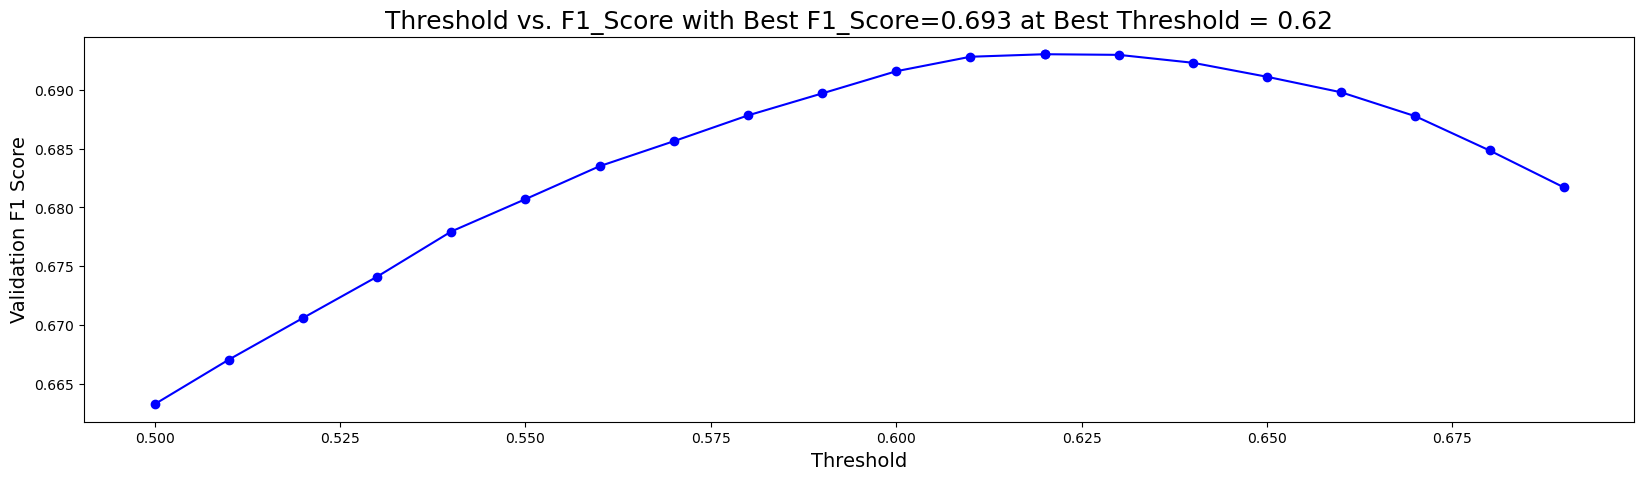

When using optimal threshold = 0.62...
Q0: F1 = 0.6628714220609848
Q1: F1 = 0.49457198026174637
Q2: F1 = 0.5027339678781766
Q3: F1 = 0.6581585318782105
Q4: F1 = 0.6166613777448346
Q5: F1 = 0.6342657265122554
Q6: F1 = 0.6212577851219736
Q7: F1 = 0.5643359241598617
Q8: F1 = 0.6191925851171763
Q9: F1 = 0.5645585568085856
Q10: F1 = 0.6106168169572022
Q11: F1 = 0.5090070032610724
Q12: F1 = 0.45460811911984694
Q13: F1 = 0.6305337458686737
Q14: F1 = 0.5861820369971682
Q15: F1 = 0.4549321747328454
Q16: F1 = 0.5513005013498824
Q17: F1 = 0.4969609413015195
==> Overall F1 = 0.6930108314960252
s


In [2]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=5)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)

    cat_params = {
        'iterations': 1000,
        'early_stopping_rounds': 90,
        'depth': 5,
        'learning_rate': 0.02,
        'loss_function': "Logloss",
        'random_seed': 222222,
        'metric_period': 1,
        'subsample': 0.8,
        'colsample_bylevel': 0.4,
        'verbose': 0,
        'l2_leaf_reg': 20,
    }
    feature_importance_df = pd.DataFrame()
    

    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]


        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])


        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]


for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

scores = []; thresholds = []
best_socre = 0; best_threshold = 0

for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color='blue')
plt.scatter([best_threshold], [best_socre], color='blue')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

In [3]:
import pickle
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()